C:\Users\arthu\AppData\Roaming\Python\Python310\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Train batches: 1273, Validation batches: 263, Test batches: 265
(4, 1, 256, 256)
(4, 1, 256, 256)


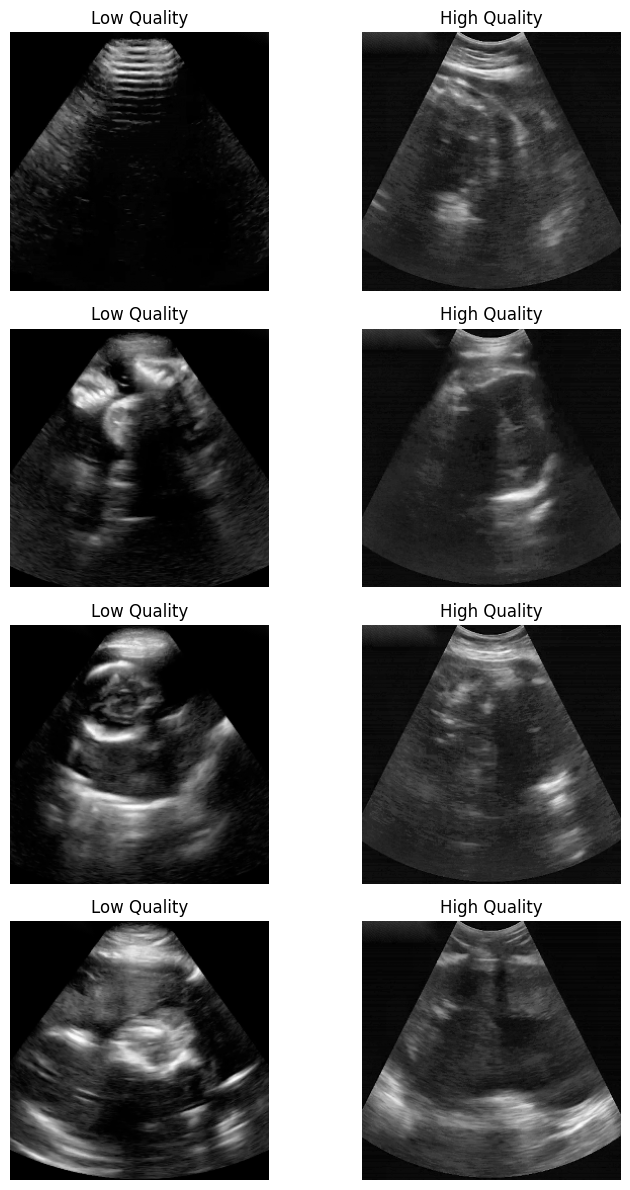

In [ ]:
import os
from gan_datamodule import ImageDataModule
import matplotlib.pyplot as plt
import numpy as np


if __name__ == "__main__":
    base_dir = "../csv"
    data_dir_low="../data/low_quality_images"
    data_dir_high="../data/high_quality_images"
    
    data_module = ImageDataModule(
        batch_size=4, 
        workers=2, 
        train_csv=os.path.join(base_dir, "train.csv"),
        val_csv=os.path.join(base_dir, "validation.csv"),
        test_csv=os.path.join(base_dir, "test.csv"),
        data_dir_low=data_dir_low,
        data_dir_high=data_dir_high
    )

    data_module.setup()

    train_loader = data_module.train_dataloader()
    val_loader = data_module.val_dataloader()
    test_loader = data_module.test_dataloader()
    print(f"Train batches: {len(train_loader)}, Validation batches: {len(val_loader)}, Test batches: {len(test_loader)}")

    # Obtain batch
    batch = next(iter(train_loader))

    # Extraer imágenes de baja y alta calidad
    low_quality_images = batch["x"].cpu().numpy()  # Convertir a numpy
    print(low_quality_images.shape)
    high_quality_images = batch["y"].cpu().numpy()
    print(high_quality_images.shape)

    # Function to show images
    def show_images(low_imgs, high_imgs, num_samples=4):
        """
        Show low and high quality images side by side.
        """
        fig, axes = plt.subplots(num_samples, 2, figsize=(8, num_samples * 3))
        
        for i in range(num_samples):
            # Normalizar para visualización
    

            low_img = (low_imgs[i] - low_imgs[i].min()) / (low_imgs[i].max() - low_imgs[i].min())
            high_img = (high_imgs[i] - high_imgs[i].min()) / (high_imgs[i].max() - high_imgs[i].min())

            # Eliminar la dimensión del canal si es de un solo canal (grayscale)
            low_img = np.squeeze(low_img)
            high_img = np.squeeze(high_img)

            # Mostrar imágenes
            axes[i, 0].imshow(low_img, cmap="gray")
            axes[i, 0].set_title("Low Quality")
            axes[i, 0].axis("off")

            axes[i, 1].imshow(high_img, cmap="gray")
            axes[i, 1].set_title("High Quality")
            axes[i, 1].axis("off")

        plt.tight_layout()
        plt.show()

    # Mostrar 4 imágenes del batch
    show_images(low_quality_images, high_quality_images, num_samples=4)

Test batches: 265


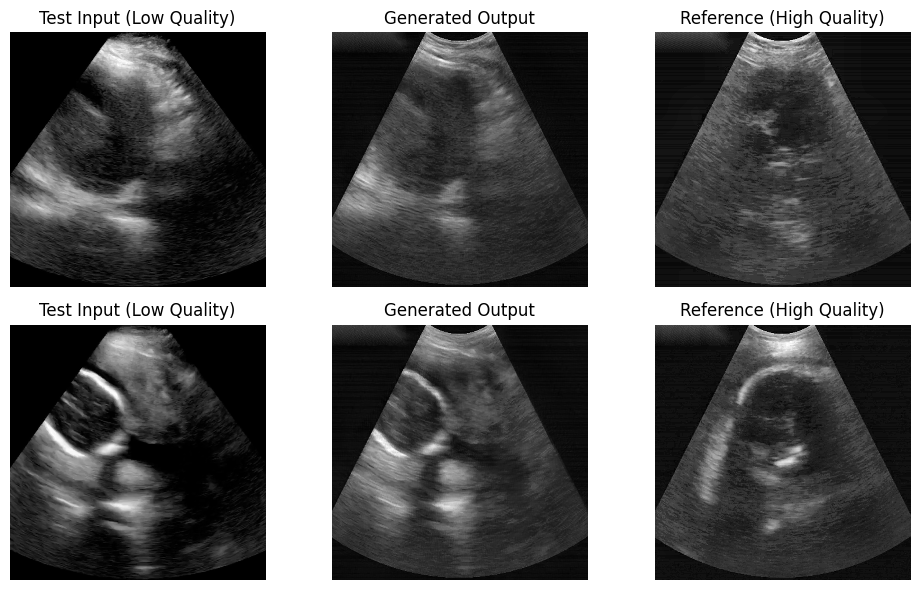

In [ ]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from gan_modules import GeneratorResNet
from gan_datamodule import ImageDataModule

# 📌 **Checkpoint paths**
checkpoint_path = "checkpoints/CycleGAN-epoch=170-val_ssim=0.4519.ckpt"
#checkpoint_path = "checkpoints/CycleGAN_15res_steplr-epoch=219-val_ssim=0.6109.ckpt"

# Generator parameters
img_channels = 1
n_residual_blocks = 9 # If the name of the checkpoint is CycleGAN_15 SET THIS NUMBER TO 15. Otherwise, it must be set to 9.

# Inicializar y cargar el generador
generator_xy = GeneratorResNet(img_channels, n_residual_blocks)
checkpoint = torch.load(checkpoint_path, map_location=torch.device("cpu"))
generator_xy.load_state_dict({k.replace("generator_xy.", ""): v for k, v in checkpoint["state_dict"].items() if "generator_xy" in k})
generator_xy.eval()

# 📌 **Load test dataset**
base_dir = "../csv"
data_dir_low="../data/low_quality_images"
data_dir_high="../data/high_quality_images"

data_module = ImageDataModule(
    batch_size=4,
    workers=2,
    train_csv=os.path.join(base_dir, "train.csv"),
    val_csv=os.path.join(base_dir, "validation.csv"),
    test_csv=os.path.join(base_dir, "test.csv"),
    data_dir_low=data_dir_low,
    data_dir_high=data_dir_high
)

data_module.setup()
test_loader = data_module.test_dataloader()
print(f"Test batches: {len(test_loader)}")

# 📌 **Obtener un batch del conjunto de prueba** / Extract a batch from test loader
batch = next(iter(test_loader))
real_x = batch["x"].to(torch.device("cpu"))  # Imágenes de baja calidad (entrada)
real_y = batch["y"].to(torch.device("cpu"))  # Imágenes de referencia (alta calidad)

# 📌 **Generar imágenes con el modelo** / Generate images with the model
with torch.no_grad():
    fake_y = generator_xy(real_x)

# Convertir a numpy para visualización / Convert to numpy for visualization
real_x_np = real_x.cpu().numpy()
fake_y_np = fake_y.cpu().numpy()
real_y_np = real_y.cpu().numpy()

# 📌 **Función para visualizar las imágenes**
def show_test_results(real_imgs, generated_imgs, reference_imgs, num_samples=4):
    """
    Muestra imágenes de entrada, sus correspondientes imágenes generadas y la referencia de alta calidad.
    """
    fig, axes = plt.subplots(num_samples, 3, figsize=(10, num_samples * 3))

    for i in range(num_samples):
        # Normalización para visualización / Normalization for visualization
        real_img = (real_imgs[i] - real_imgs[i].min()) / (real_imgs[i].max() - real_imgs[i].min())
        gen_img = (generated_imgs[i] - generated_imgs[i].min()) / (generated_imgs[i].max() - generated_imgs[i].min())
        ref_img = (reference_imgs[i] - reference_imgs[i].min()) / (reference_imgs[i].max() - reference_imgs[i].min())

        # Eliminar la dimensión del canal si es una imagen en escala de grises / Delete the channel dimension if it's a grayscale image
        real_img = np.squeeze(real_img)
        gen_img = np.squeeze(gen_img)
        ref_img = np.squeeze(ref_img)

        # Mostrar imágenes / Show images
        axes[i, 0].imshow(real_img, cmap="gray")
        axes[i, 0].set_title("Test Input (Low Quality)")
        axes[i, 0].axis("off")

        axes[i, 1].imshow(gen_img, cmap="gray")
        axes[i, 1].set_title("Generated Output")
        axes[i, 1].axis("off")

        axes[i, 2].imshow(ref_img, cmap="gray")
        axes[i, 2].set_title("Reference (High Quality)")
        axes[i, 2].axis("off")

    plt.tight_layout()
    plt.show()

# 📌 **Mostrar imágenes del conjunto de prueba** / Show sample images
show_test_results(real_x_np, fake_y_np, real_y_np, num_samples=2)

In [ ]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

from gan_model import GeneratorResNet
from gan_datamodule import ImageDataModule
from metrics import compute_tsne

##############################################
# 1) Configuration for GPU usage
##############################################
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Checkpoint path
checkpoint_path = "checkpoints/CycleGAN-epoch=170-val_ssim=0.4519.ckpt"
# If you have a 15-block checkpoint, set n_residual_blocks=15:
# checkpoint_path = "checkpoints/CycleGAN_15res_steplr-epoch=219-val_ssim=0.6109.ckpt"

# Generator parameters
img_channels = 1
n_residual_blocks = 9

##############################################
# 2) Initialize and load the Generator on GPU
##############################################
generator_xy = GeneratorResNet(img_channels, n_residual_blocks)
checkpoint = torch.load(checkpoint_path, map_location=device)
generator_xy.load_state_dict({
    k.replace("generator_xy.", ""): v
    for k, v in checkpoint["state_dict"].items()
    if "generator_xy" in k
})
generator_xy.to(device)
generator_xy.eval()

##############################################
# 3) Set up data module and test loader
##############################################
base_dir = "../csv"
data_dir_low = "../data/low_quality_images"
data_dir_high = "../data/high_quality_images"

data_module = ImageDataModule(
    batch_size=4,
    workers=2,
    train_csv=os.path.join(base_dir, "train.csv"),
    val_csv=os.path.join(base_dir, "validation.csv"),
    test_csv=os.path.join(base_dir, "test.csv"),
    data_dir_low=data_dir_low,
    data_dir_high=data_dir_high
)

data_module.setup()
test_loader = data_module.test_dataloader()
print(f"Number of test batches: {len(test_loader)}")

##############################################
# 4) Collect ALL test data for t-SNE on GPU
##############################################
all_low = []
all_high_before = []
all_fake = []
all_high_after = []

with torch.no_grad():
    for batch in tqdm(test_loader, desc = "Batch processing", unit="batch"):
        real_x = batch["x"].to(device)  # Move low-quality to GPU
        real_y = batch["y"].to(device)  # Move high-quality to GPU
        B = real_x.shape[0]

        # 4A) Flatten on GPU, then copy to CPU
        low_feats_gpu = real_x.view(B, -1)
        high_feats_gpu = real_y.view(B, -1)

        low_feats = low_feats_gpu.cpu().numpy()
        high_feats = high_feats_gpu.cpu().numpy()

        # Accumulate the "before" data
        all_low.append(low_feats)
        all_high_before.append(high_feats)

        # 4B) Generate fake images on GPU, flatten on GPU, then CPU
        fake_y = generator_xy(real_x)  # still on GPU
        fake_feats_gpu = fake_y.view(B, -1)

        fake_feats = fake_feats_gpu.cpu().numpy()
        # We'll reuse the same real_y for "after"
        all_fake.append(fake_feats)
        all_high_after.append(high_feats)

##############################################
# 5) Concatenate everything
##############################################
all_low = np.concatenate(all_low, axis=0)          # shape: (N, C*H*W)
all_high_before = np.concatenate(all_high_before, axis=0)
all_fake = np.concatenate(all_fake, axis=0)
all_high_after = np.concatenate(all_high_after, axis=0)

# "before": low vs high
features_before = np.concatenate([all_low, all_high_before], axis=0)
labels_before = np.array([0]*len(all_low) + [1]*len(all_high_before))

tsne_coords_before, tsne_labels_before = compute_tsne(features_before, labels_before)

# "after": fake vs high
features_after = np.concatenate([all_fake, all_high_after], axis=0)
labels_after = np.array([0]*len(all_fake) + [1]*len(all_high_after))

tsne_coords_after, tsne_labels_after = compute_tsne(features_after, labels_after)

##############################################
# 6) Plot results
##############################################
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# BEFORE
ax1 = axes[0]
for lbl in [0, 1]:
    idxs = (tsne_labels_before == lbl)
    ax1.scatter(tsne_coords_before[idxs, 0],
                tsne_coords_before[idxs, 1],
                label="Low" if lbl == 0 else "High",
                alpha=0.6)
ax1.set_xlabel("t-SNE Dim 1")
ax1.set_ylabel("t-SNE Dim 2")
ax1.set_title("t-SNE Before: Low vs High for Gan_9")
ax1.legend()

# AFTER
ax2 = axes[1]
for lbl in [0, 1]:
    idxs = (tsne_labels_after == lbl)
    ax2.scatter(tsne_coords_after[idxs, 0],
                tsne_coords_after[idxs, 1],
                label="Fake" if lbl == 0 else "High",
                alpha=0.6)
ax2.set_xlabel("t-SNE Dim 1")
ax2.set_ylabel("t-SNE Dim 2")
ax2.set_title("t-SNE After: Fake vs High for Gan_9")
ax2.legend()

plt.tight_layout()
plt.show()


Using device: cuda
Number of test batches: 265


Batch processing:  62%|██████▏   | 163/265 [00:19<00:04, 24.88batch/s]

Using device: cuda
Number of test batches: 265


Batch processing: 100%|██████████| 265/265 [00:27<00:00,  9.73batch/s]


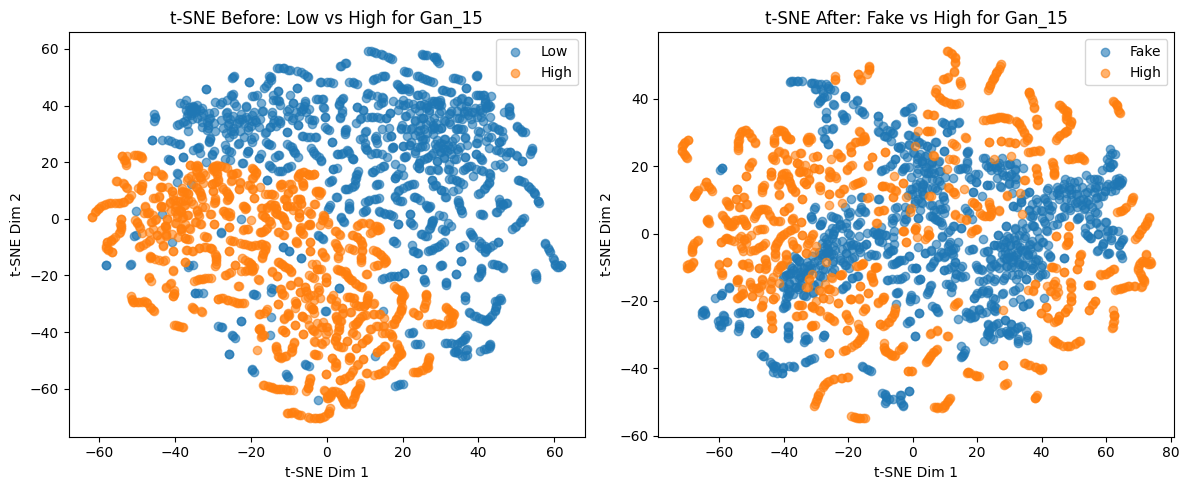

In [ ]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

from gan_modules import GeneratorResNet
from gan_datamodule import ImageDataModule
from metrics import compute_tsne

##############################################
# 1) Configuration for GPU usage
##############################################
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Checkpoint path
# checkpoint_path = "checkpoints/CycleGAN-epoch=170-val_ssim=0.4519.ckpt"
# If you have a 15-block checkpoint, set n_residual_blocks=15:
checkpoint_path = "checkpoints/CycleGAN_15res_steplr-epoch=219-val_ssim=0.6109.ckpt"

# Generator parameters
img_channels = 1
n_residual_blocks = 15

##############################################
# 2) Initialize and load the Generator on GPU
##############################################
generator_xy = GeneratorResNet(img_channels, n_residual_blocks)
checkpoint = torch.load(checkpoint_path, map_location=device)
generator_xy.load_state_dict({
    k.replace("generator_xy.", ""): v
    for k, v in checkpoint["state_dict"].items()
    if "generator_xy" in k
})
generator_xy.to(device)
generator_xy.eval()

##############################################
# 3) Set up data module and test loader
##############################################
base_dir = "../csv"
data_dir_low = "../data/low_quality_images"
data_dir_high = "../data/high_quality_images"

data_module = ImageDataModule(
    batch_size=4,
    workers=2,
    train_csv=os.path.join(base_dir, "train.csv"),
    val_csv=os.path.join(base_dir, "validation.csv"),
    test_csv=os.path.join(base_dir, "test.csv"),
    data_dir_low=data_dir_low,
    data_dir_high=data_dir_high
)

data_module.setup()
test_loader = data_module.test_dataloader()
print(f"Number of test batches: {len(test_loader)}")

##############################################
# 4) Collect ALL test data for t-SNE on GPU
##############################################
all_low = []
all_high_before = []
all_fake = []
all_high_after = []

with torch.no_grad():
    for batch in tqdm(test_loader, desc = "Batch processing", unit="batch"):
        real_x = batch["x"].to(device)  # Move low-quality to GPU
        real_y = batch["y"].to(device)  # Move high-quality to GPU
        B = real_x.shape[0]

        # 4A) Flatten on GPU, then copy to CPU
        low_feats_gpu = real_x.view(B, -1)
        high_feats_gpu = real_y.view(B, -1)

        low_feats = low_feats_gpu.cpu().numpy()
        high_feats = high_feats_gpu.cpu().numpy()

        # Accumulate the "before" data
        all_low.append(low_feats)
        all_high_before.append(high_feats)

        # 4B) Generate fake images on GPU, flatten on GPU, then CPU
        fake_y = generator_xy(real_x)  # still on GPU
        fake_feats_gpu = fake_y.view(B, -1)

        fake_feats = fake_feats_gpu.cpu().numpy()
        # We'll reuse the same real_y for "after"
        all_fake.append(fake_feats)
        all_high_after.append(high_feats)

##############################################
# 5) Concatenate everything
##############################################
all_low = np.concatenate(all_low, axis=0)          # shape: (N, C*H*W)
all_high_before = np.concatenate(all_high_before, axis=0)
all_fake = np.concatenate(all_fake, axis=0)
all_high_after = np.concatenate(all_high_after, axis=0)

# "before": low vs high
features_before = np.concatenate([all_low, all_high_before], axis=0)
labels_before = np.array([0]*len(all_low) + [1]*len(all_high_before))

tsne_coords_before, tsne_labels_before = compute_tsne(features_before, labels_before)

# "after": fake vs high
features_after = np.concatenate([all_fake, all_high_after], axis=0)
labels_after = np.array([0]*len(all_fake) + [1]*len(all_high_after))

tsne_coords_after, tsne_labels_after = compute_tsne(features_after, labels_after)

##############################################
# 6) Plot results
##############################################
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# BEFORE
ax1 = axes[0]
for lbl in [0, 1]:
    idxs = (tsne_labels_before == lbl)
    ax1.scatter(tsne_coords_before[idxs, 0],
                tsne_coords_before[idxs, 1],
                label="Low" if lbl == 0 else "High",
                alpha=0.6)
ax1.set_xlabel("t-SNE Dim 1")
ax1.set_ylabel("t-SNE Dim 2")
ax1.set_title("t-SNE Before: Low vs High for Gan_15")
ax1.legend()

# AFTER
ax2 = axes[1]
for lbl in [0, 1]:
    idxs = (tsne_labels_after == lbl)
    ax2.scatter(tsne_coords_after[idxs, 0],
                tsne_coords_after[idxs, 1],
                label="Fake" if lbl == 0 else "High",
                alpha=0.6)
ax2.set_xlabel("t-SNE Dim 1")
ax2.set_ylabel("t-SNE Dim 2")
ax2.set_title("t-SNE After: Fake vs High for Gan_15")
ax2.legend()

plt.tight_layout()
plt.show()


C:\Users\arthu\AppData\Roaming\Python\Python310\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: cuda
Number of test batches: 265
Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]


C:\Users\arthu\AppData\Roaming\Python\Python310\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\arthu\AppData\Roaming\Python\Python310\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: C:\Users\arthu\AppData\Roaming\Python\Python310\site-packages\lpips\weights\v0.1\vgg.pth
Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: C:\Users\arthu\AppData\Roaming\Python\Python310\site-packages\lpips\weights\v0.1\vgg.pth


Gathering metrics: 100%|██████████| 265/265 [00:43<00:00,  6.08it/s]
C:\Users\arthu\AppData\Local\Temp\ipykernel_10836\3284579929.py:126: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot([data_9, data_15], labels=["9-blocks", "15-blocks"])


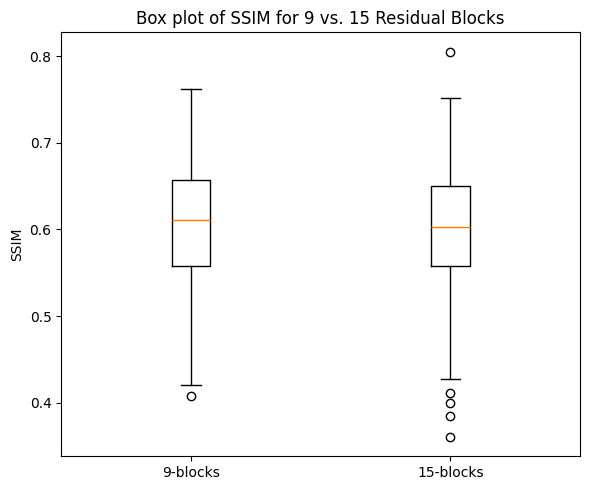

C:\Users\arthu\AppData\Local\Temp\ipykernel_10836\3284579929.py:126: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot([data_9, data_15], labels=["9-blocks", "15-blocks"])


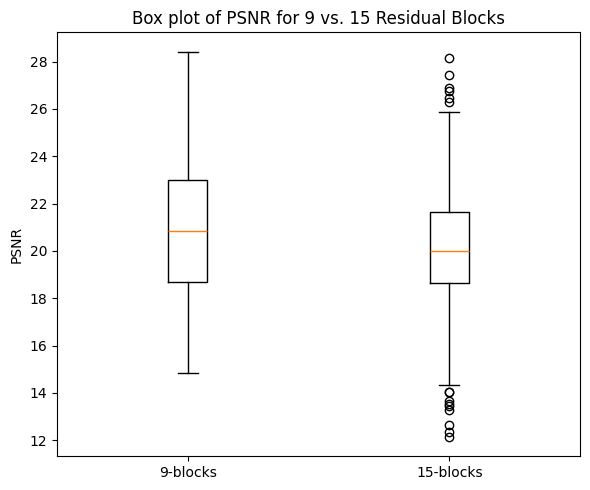

C:\Users\arthu\AppData\Local\Temp\ipykernel_10836\3284579929.py:126: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot([data_9, data_15], labels=["9-blocks", "15-blocks"])


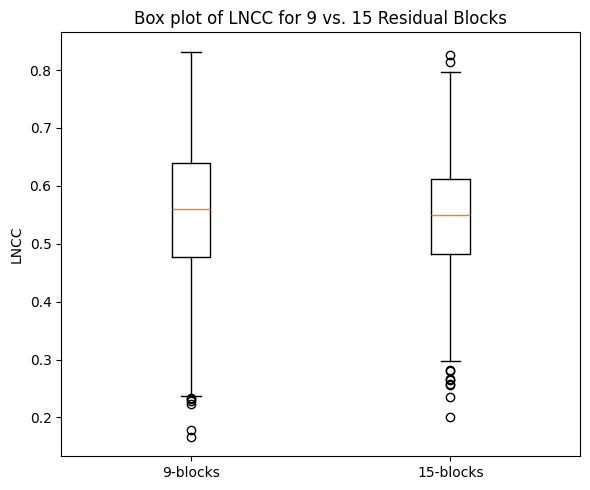

C:\Users\arthu\AppData\Local\Temp\ipykernel_10836\3284579929.py:126: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot([data_9, data_15], labels=["9-blocks", "15-blocks"])


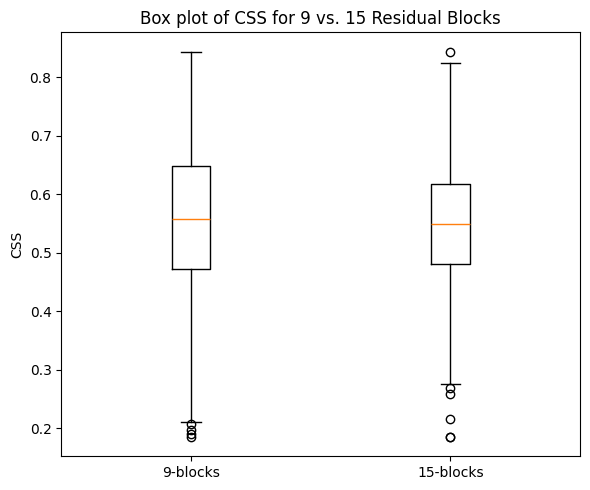

C:\Users\arthu\AppData\Local\Temp\ipykernel_10836\3284579929.py:126: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot([data_9, data_15], labels=["9-blocks", "15-blocks"])


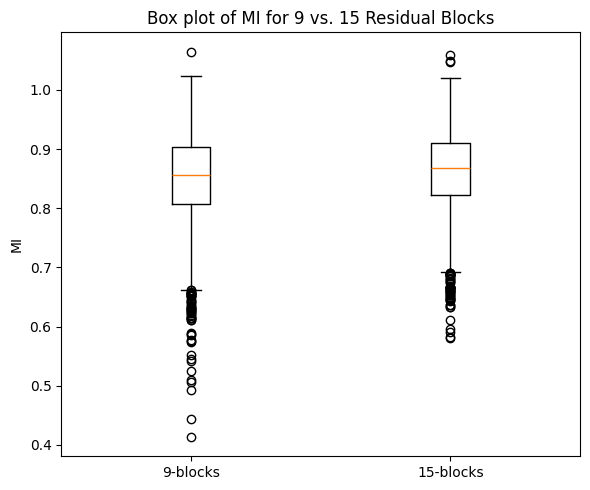

C:\Users\arthu\AppData\Local\Temp\ipykernel_10836\3284579929.py:126: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot([data_9, data_15], labels=["9-blocks", "15-blocks"])


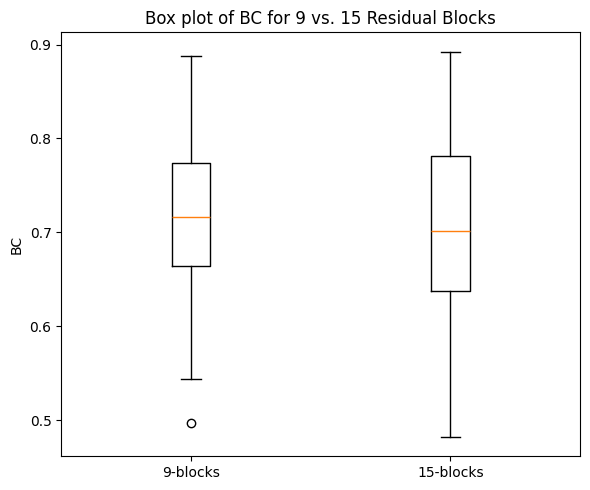

C:\Users\arthu\AppData\Local\Temp\ipykernel_10836\3284579929.py:126: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot([data_9, data_15], labels=["9-blocks", "15-blocks"])


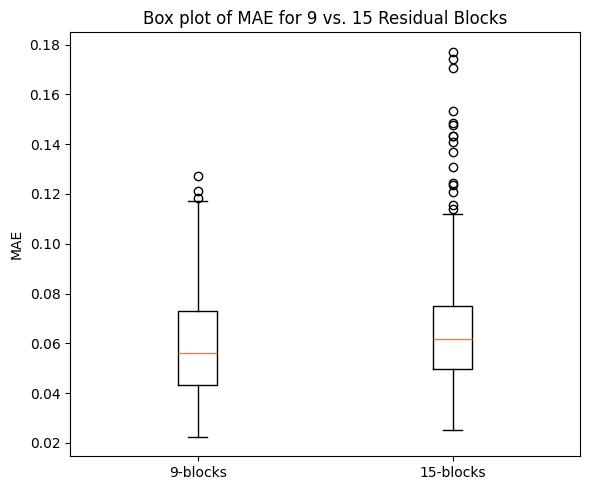

In [ ]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

from gan_model_torch import CycleGAN
from gan_datamodule import ImageDataModule

##########################
# Configuration
##########################
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Example checkpoints
checkpoint_9 = "checkpoints/CycleGAN-epoch=170-val_ssim=0.4519.ckpt"
checkpoint_15 = "checkpoints/CycleGAN_15res_steplr-epoch=219-val_ssim=0.6109.ckpt"

# For the 9-block checkpoint
RES_BLOCKS_9 = 9
# For the 15-block checkpoint
RES_BLOCKS_15 = 15

# Data paths
base_dir = "../csv"
data_dir_low = "../data/low_quality_images"
data_dir_high = "../data/high_quality_images"

##########################
# 1) Helper: load model from checkpoint
##########################
def load_cyclegan_model(checkpoint_path, n_residual_blocks):
    """Loads a CycleGAN from a given checkpoint and sets the correct # of residual blocks."""
    # Construct the model with the correct # of residual blocks
    model = CycleGAN(img_channels=1, n_residual_blocks=n_residual_blocks)
    ckpt = torch.load(checkpoint_path, map_location=device)

    # Lightning checkpoints store "state_dict" containing both generator/discriminator
    # Typically we can do "model.load_state_dict(ckpt['state_dict'])"
    model.load_state_dict(ckpt["state_dict"], strict=False)
    model.to(device)
    model.eval()
    return model

##########################
# 2) Helper: gather metrics from test set
##########################
def gather_statistics(model: CycleGAN, test_loader):
    """
    Iterates over the test_loader, calls model.statistics_step() for each batch,
    and accumulates the per-image metrics for the entire test set.

    Returns a dict containing lists for each metric.
    """
    # Prepare accumulators
    all_ssim = []
    all_psnr = []
    all_css  = []
    all_mi   = []
    all_bc   = []
    all_mae  = []
    all_lncc = []  # if you want LNCC as well

    model.eval()
    with torch.no_grad():
        for batch_idx, batch in enumerate(tqdm(test_loader, desc="Gathering metrics")):
            (
                ssim_scores, psnr_scores,
                lncc_scores, css_scores,
                mi_scores, bc_scores, mae_scores
            ) = model._compute_individual_metrics(batch)

            all_ssim.extend(ssim_scores)
            all_psnr.extend(psnr_scores)
            all_lncc.extend(lncc_scores)
            all_css.extend(css_scores)
            all_mi.extend(mi_scores)
            all_bc.extend(bc_scores)
            all_mae.extend(mae_scores)

    return {
        "ssim": all_ssim,
        "psnr": all_psnr,
        "lncc": all_lncc,
        "css":  all_css,
        "mi":   all_mi,
        "bc":   all_bc,
        "mae":  all_mae
    }

##########################
# 3) Main: load data, evaluate both models, plot
##########################
if __name__ == "__main__":
    # Setup data
    data_module = ImageDataModule(
        batch_size=4,
        workers=2,
        train_csv=os.path.join(base_dir, "train.csv"),
        val_csv=os.path.join(base_dir, "validation.csv"),
        test_csv=os.path.join(base_dir, "test.csv"),
        data_dir_low=data_dir_low,
        data_dir_high=data_dir_high
    )
    data_module.setup()
    test_loader = data_module.test_dataloader()
    print("Number of test batches:", len(test_loader))

    # Load both models
    model_9  = load_cyclegan_model(checkpoint_9,  RES_BLOCKS_9)
    model_15 = load_cyclegan_model(checkpoint_15, RES_BLOCKS_15)

    # Gather metrics for each
    stats_9  = gather_statistics(model_9,  test_loader)
    stats_15 = gather_statistics(model_15, test_loader)

    # We want 7 box plots: ssim, psnr, css, mi, bc, mae
    metric_names = ["ssim", "psnr", "lncc", "css", "mi", "bc", "mae"]

    for metric_name in metric_names:
        data_9 = stats_9[metric_name]
        data_15= stats_15[metric_name]

        fig, ax = plt.subplots(figsize=(6,5))
        ax.boxplot([data_9, data_15], labels=["9-blocks", "15-blocks"])
        ax.set_title(f"Box plot of {metric_name.upper()} for 9 vs. 15 Residual Blocks")
        ax.set_ylabel(metric_name.upper())
        plt.tight_layout()
        plt.show()

Using device: cuda
Number of test batches: 265
Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]


C:\Users\arthu\AppData\Roaming\Python\Python310\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\arthu\AppData\Roaming\Python\Python310\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: C:\Users\arthu\AppData\Roaming\Python\Python310\site-packages\lpips\weights\v0.1\vgg.pth
Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: C:\Users\arthu\AppData\Roaming\Python\Python310\site-packages\lpips\weights\v0.1\vgg.pth


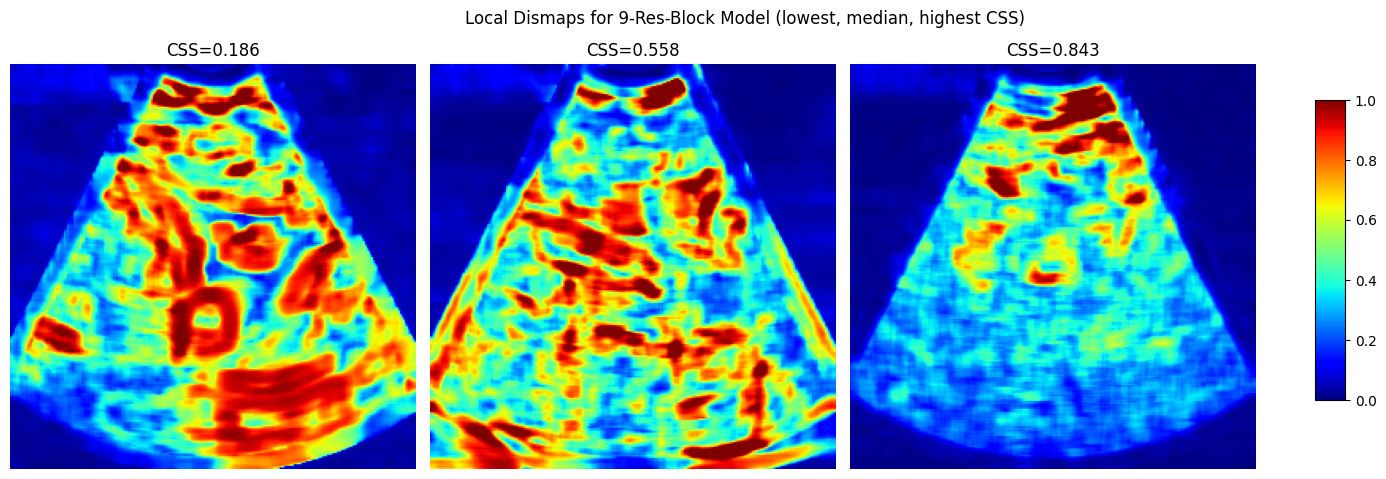

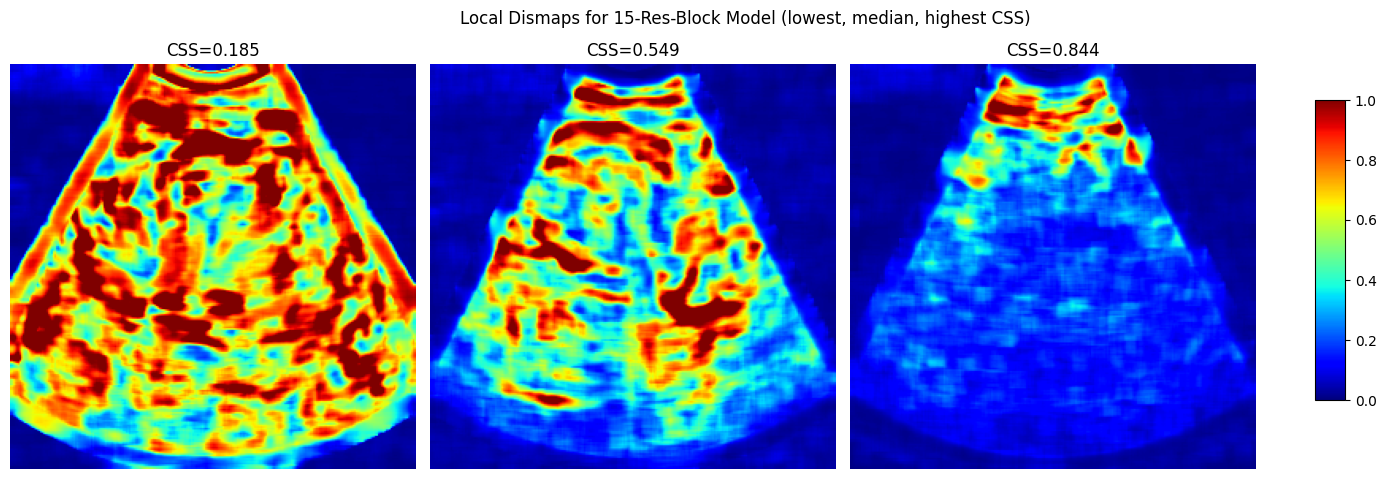

Done! Generated two figures with local dismaps (lowest, median, highest CSS) for each model.


In [ ]:
import os
import numpy as np
import torch
import matplotlib.pyplot as plt
from tqdm import tqdm

# Import your model & DataModule
from gan_model import CycleGAN
from gan_datamodule import ImageDataModule

# Import the local CSS/dismap functions from your metrics
from metrics import local_css_map, local_dismap, contrast_structure_similarity

##################################
# 1) Config
##################################
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Paths to two different checkpoints
checkpoint_9  = "checkpoints/CycleGAN-epoch=170-val_ssim=0.4519.ckpt"
checkpoint_15 = "checkpoints/CycleGAN_15res_steplr-epoch=219-val_ssim=0.6109.ckpt"

RES_BLOCKS_9  = 9
RES_BLOCKS_15 = 15

base_dir = "../csv"
data_dir_low  = "../data/low_quality_images"
data_dir_high = "../data/high_quality_images"

# We'll assume you want batch_size=4, etc. Feel free to modify
BATCH_SIZE = 4
WORKERS    = 2

##################################
# 2) load_cyclegan_model function
##################################
def load_cyclegan_model(checkpoint_path, n_residual_blocks):
    """Construct a CycleGAN with the given number of residual blocks,
    load the checkpoint, move to GPU/CPU, return the model in eval mode."""
    model = CycleGAN(
        img_channels=1,
        n_residual_blocks=n_residual_blocks
    )
    ckpt = torch.load(checkpoint_path, map_location=device)
    model.load_state_dict(ckpt["state_dict"], strict=False)
    model.to(device)
    model.eval()
    return model

##################################
# 3) main logic
##################################
if __name__ == "__main__":
    # Set up the DataModule
    data_module = ImageDataModule(
        batch_size=BATCH_SIZE,
        workers=WORKERS,
        train_csv=os.path.join(base_dir, "train.csv"),
        val_csv=os.path.join(base_dir, "validation.csv"),
        test_csv=os.path.join(base_dir, "test.csv"),
        data_dir_low=data_dir_low,
        data_dir_high=data_dir_high
    )
    data_module.setup()
    test_loader = data_module.test_dataloader()
    print("Number of test batches:", len(test_loader))

    # Load 2 different models
    model_9  = load_cyclegan_model(checkpoint_9,  RES_BLOCKS_9)
    model_15 = load_cyclegan_model(checkpoint_15, RES_BLOCKS_15)

    # We'll define a helper that:
    # 1) runs the model on the test set
    # 2) calculates global CSS = contrast_structure_similarity(fake_y, real_y)
    # 3) stores (css_value, real_y_np, fake_y_np) for each sample
    # 4) returns a big list of these
    def collect_css_samples(cyclegan_model, loader):
        cyclegan_model.eval()
        css_samples = []
        with torch.no_grad():
            for batch_idx, batch in enumerate(tqdm(loader, desc="Collecting CSS")):
                real_x = batch["x"].to(device)
                real_y = batch["y"].to(device)

                fake_y = cyclegan_model.generator_xy(real_x)

                B = real_y.shape[0]
                for i in range(B):
                    # Convert from [-1,1] to [0,1]:
                    ry = (real_y[i].cpu().numpy().squeeze() + 1)/2
                    fy = (fake_y[i].cpu().numpy().squeeze() + 1)/2

                    # Global CSS
                    global_css = contrast_structure_similarity(fy, ry)
                    css_samples.append({
                        "css": global_css,
                        "real_y": ry,
                        "fake_y": fy
                    })
        return css_samples

    # Collect CSS for each model
    css_9  = collect_css_samples(model_9,  test_loader)
    css_15 = collect_css_samples(model_15, test_loader)

    # Sort by css ascending
    css_9_sorted  = sorted(css_9,  key=lambda x: x["css"])
    css_15_sorted = sorted(css_15, key=lambda x: x["css"])

    # pick min, median, max index
    def get_min_med_max(sorted_list):
        n = len(sorted_list)
        min_idx = 0
        max_idx = n-1
        med_idx = n//2  # integer division
        return [min_idx, med_idx, max_idx]

    idx_9  = get_min_med_max(css_9_sorted)
    idx_15 = get_min_med_max(css_15_sorted)

    # We'll now produce local dismaps for each of these 3 examples per model
    # We'll create 2 big figures: one for model_9, one for model_15
    # Each figure has 3 subplots: [lowest, median, highest]

    # A small helper to do local dismap
    def compute_dismap(real_y_np, fake_y_np, window_size=11):
        # local_dismap uses local_css_map inside. 0..1 scale
        return local_dismap(real_y_np, fake_y_np, window_size=window_size, scale=1)

 # 4) Plot for model_9 (make figure a bit bigger)
    fig_9, axs_9 = plt.subplots(1, 3, figsize=(15, 5))
    fig_9.suptitle("Local Dismaps for 9-Res-Block Model (lowest, median, highest CSS)")
    for plot_i, idx_i in enumerate(idx_9):
        example = css_9_sorted[idx_i]
        local_dm = compute_dismap(example["real_y"], example["fake_y"], 11)
        ax = axs_9[plot_i]
        img_9 = ax.imshow(local_dm, cmap="jet", vmin=0, vmax=1)
        ax.set_title(f"CSS={example['css']:.3f}")
        ax.axis("off")

    # Tight layout but leave space on the right for colorbar:
    plt.tight_layout(rect=[0, 0, 0.85, 1])  # subplots only occupy left 85% of figure
    # Manually create an axis for the colorbar on the right:
    cbar_ax_9 = fig_9.add_axes([0.88, 0.2, 0.02, 0.6])  # [left, bottom, width, height]
    fig_9.colorbar(img_9, cax=cbar_ax_9)

    plt.show()

    # 5) Plot for model_15 (same approach)
    fig_15, axs_15 = plt.subplots(1, 3, figsize=(15, 5))
    fig_15.suptitle("Local Dismaps for 15-Res-Block Model (lowest, median, highest CSS)")
    for plot_i, idx_i in enumerate(idx_15):
        example = css_15_sorted[idx_i]
        local_dm = compute_dismap(example["real_y"], example["fake_y"], 11)
        ax = axs_15[plot_i]
        img_15 = ax.imshow(local_dm, cmap="jet", vmin=0, vmax=1)
        ax.set_title(f"CSS={example['css']:.3f}")
        ax.axis("off")

    plt.tight_layout(rect=[0, 0, 0.85, 1])
    cbar_ax_15 = fig_15.add_axes([0.88, 0.2, 0.02, 0.6])
    fig_15.colorbar(img_15, cax=cbar_ax_15)

    plt.show()

    print("Done! Generated two figures with local dismaps (lowest, median, highest CSS) for each model!")

C:\Users\arthu\AppData\Roaming\Python\Python310\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: cuda
Number of test batches: 265
Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]


C:\Users\arthu\AppData\Roaming\Python\Python310\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\arthu\AppData\Roaming\Python\Python310\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: C:\Users\arthu\AppData\Roaming\Python\Python310\site-packages\lpips\weights\v0.1\vgg.pth
Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: C:\Users\arthu\AppData\Roaming\Python\Python310\site-packages\lpips\weights\v0.1\vgg.pth


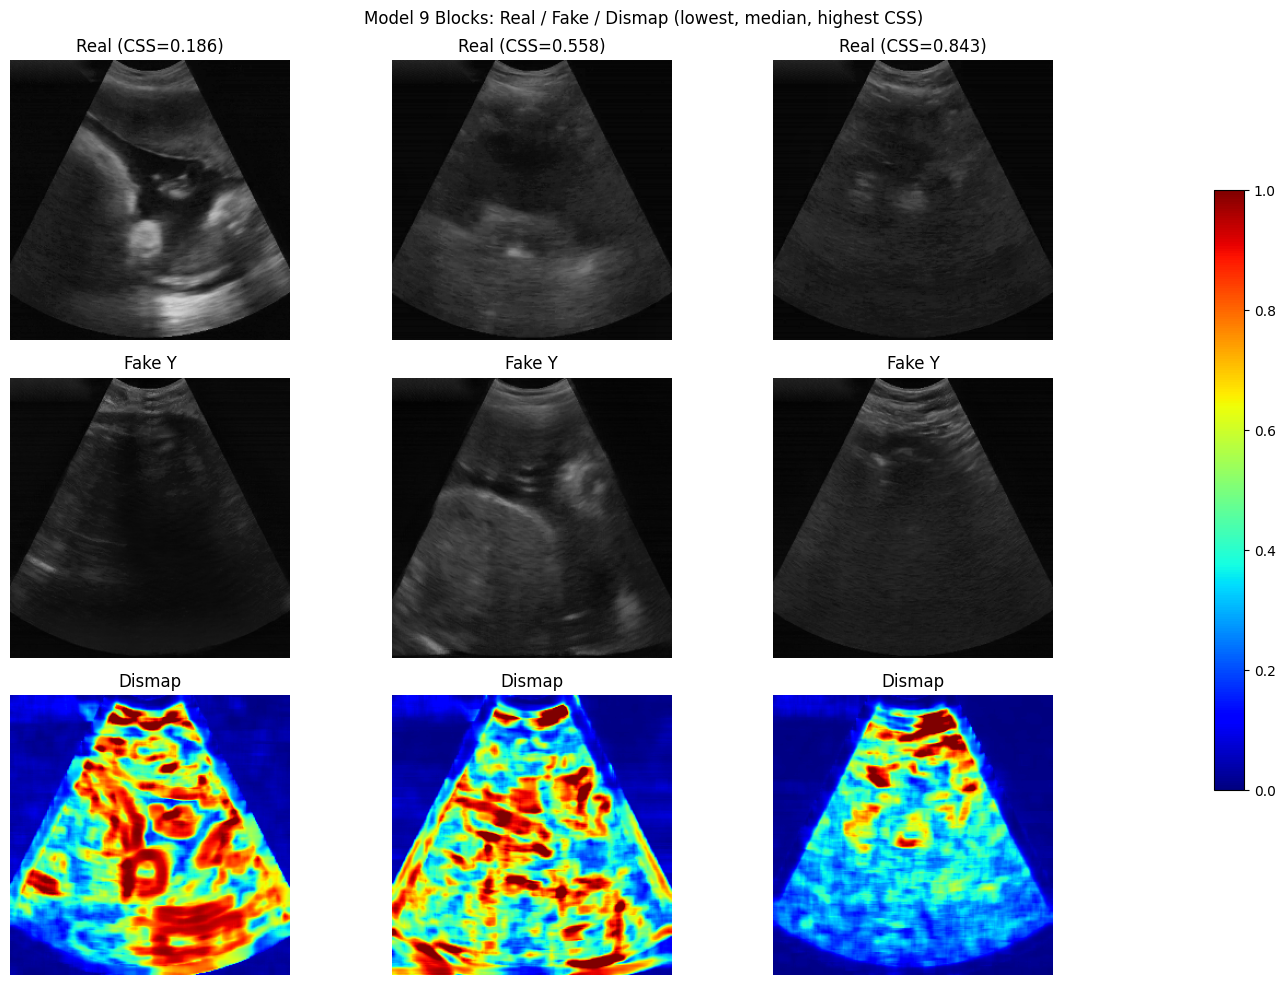

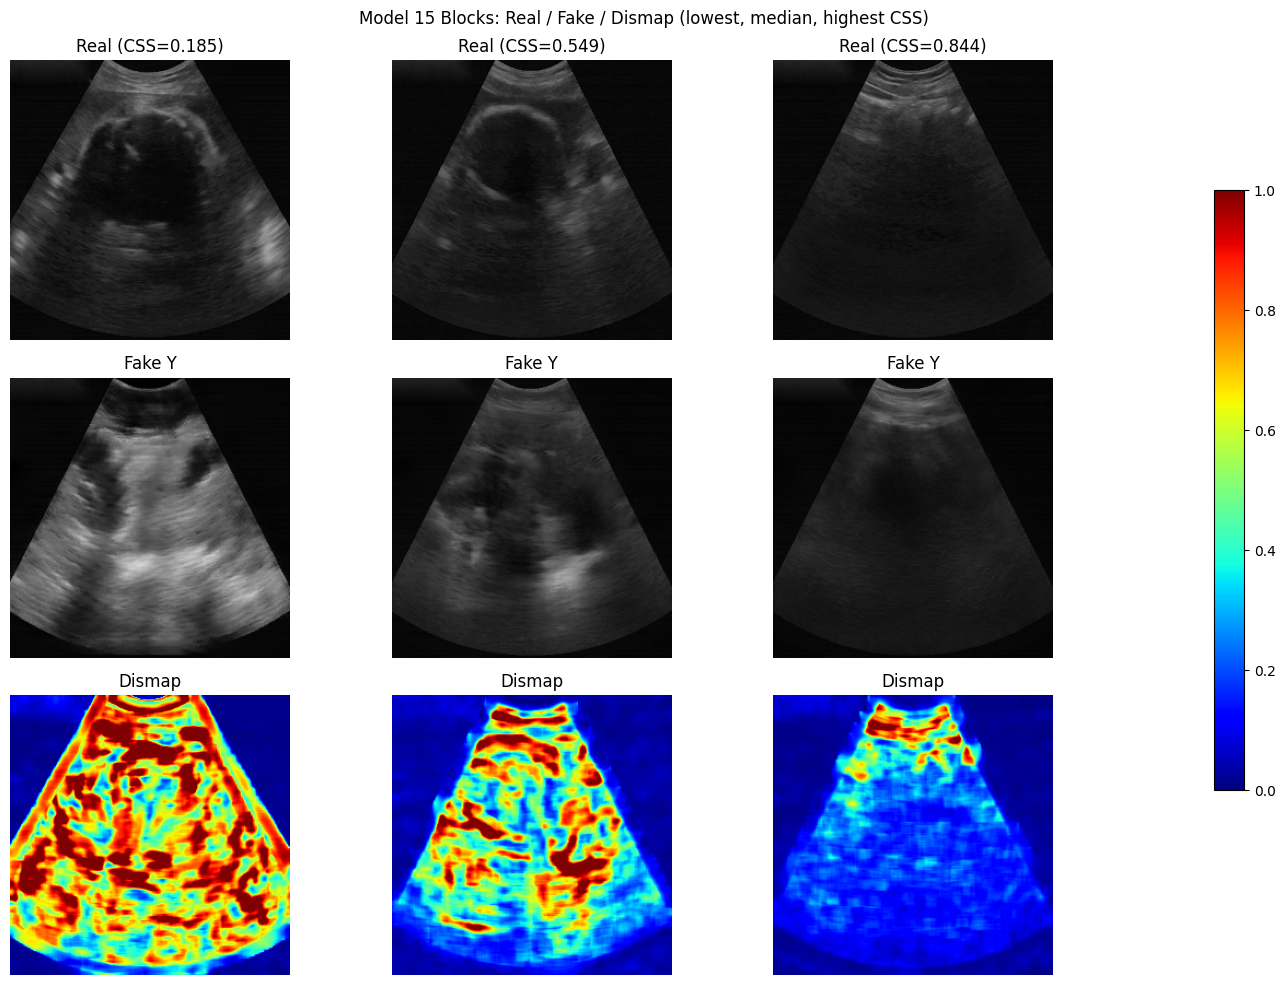

Done! Generated two figures with [Real, Fake, Dismap] for min/median/max CSS in each model.


In [ ]:
import os
import numpy as np
import torch
import matplotlib.pyplot as plt
from tqdm import tqdm

# Import your model & DataModule
from gan_model import CycleGAN
from gan_datamodule import ImageDataModule

# Import the local CSS/dismap functions from your metrics
from metrics import local_css_map, local_dismap, contrast_structure_similarity

##################################
# 1) Config
##################################
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Paths to two different checkpoints
checkpoint_9  = "checkpoints/CycleGAN-epoch=170-val_ssim=0.4519.ckpt"
checkpoint_15 = "checkpoints/CycleGAN_15res_steplr-epoch=219-val_ssim=0.6109.ckpt"

RES_BLOCKS_9  = 9
RES_BLOCKS_15 = 15

base_dir = "../csv"
data_dir_low  = "../data/low_quality_images"
data_dir_high = "../data/high_quality_images"

# We'll assume you want batch_size=4, etc. Feel free to modify
BATCH_SIZE = 4
WORKERS    = 2

##################################
# 2) load_cyclegan_model function
##################################
def load_cyclegan_model(checkpoint_path, n_residual_blocks):
    """Construct a CycleGAN with the given number of residual blocks,
    load the checkpoint, move to GPU/CPU, return the model in eval mode."""
    model = CycleGAN(
        img_channels=1,
        n_residual_blocks=n_residual_blocks
    )
    ckpt = torch.load(checkpoint_path, map_location=device)
    model.load_state_dict(ckpt["state_dict"], strict=False)
    model.to(device)
    model.eval()
    return model

##################################
# 3) Main logic
##################################
if __name__ == "__main__":
    # Set up the DataModule
    data_module = ImageDataModule(
        batch_size=BATCH_SIZE,
        workers=WORKERS,
        train_csv=os.path.join(base_dir, "train.csv"),
        val_csv=os.path.join(base_dir, "validation.csv"),
        test_csv=os.path.join(base_dir, "test.csv"),
        data_dir_low=data_dir_low,
        data_dir_high=data_dir_high
    )
    data_module.setup()
    test_loader = data_module.test_dataloader()
    print("Number of test batches:", len(test_loader))

    # Load 2 different models
    model_9  = load_cyclegan_model(checkpoint_9,  RES_BLOCKS_9)
    model_15 = load_cyclegan_model(checkpoint_15, RES_BLOCKS_15)

    # Helper to run model and collect global CSS for each sample
    def collect_css_samples(cyclegan_model, loader):
        cyclegan_model.eval()
        css_samples = []
        with torch.no_grad():
            for batch_idx, batch in enumerate(tqdm(loader, desc="Collecting CSS")):
                real_x = batch["x"].to(device)
                real_y = batch["y"].to(device)

                # Generate fake images
                fake_y = cyclegan_model.generator_xy(real_x)

                B = real_y.shape[0]
                for i in range(B):
                    # Convert from [-1,1] to [0,1]:
                    ry = (real_y[i].cpu().numpy().squeeze() + 1)/2
                    fy = (fake_y[i].cpu().numpy().squeeze() + 1)/2

                    # Global CSS
                    global_css = contrast_structure_similarity(fy, ry)
                    css_samples.append({
                        "css": global_css,
                        "real_y": ry,
                        "fake_y": fy
                    })
        return css_samples

    # Collect CSS for each model
    css_9  = collect_css_samples(model_9,  test_loader)
    css_15 = collect_css_samples(model_15, test_loader)

    # Sort by css ascending
    css_9_sorted  = sorted(css_9,  key=lambda x: x["css"])
    css_15_sorted = sorted(css_15, key=lambda x: x["css"])

    # pick min, median, max index
    def get_min_med_max(sorted_list):
        n = len(sorted_list)
        if n == 0:
            return []
        min_idx = 0
        max_idx = n - 1
        med_idx = n // 2  # integer division
        return [min_idx, med_idx, max_idx]

    idx_9  = get_min_med_max(css_9_sorted)
    idx_15 = get_min_med_max(css_15_sorted)

    # Helper to do local dismap
    def compute_dismap(real_y_np, fake_y_np, window_size=11):
        # local_dismap uses local_css_map inside. 0..1 scale
        return local_dismap(real_y_np, fake_y_np, window_size=window_size, scale=1)

   ############################
    # 4) Plot for model_9
    ############################
    # Make figure a bit bigger, e.g. 3x3 subplots => (15,10)
    fig_9, axs_9 = plt.subplots(3, 3, figsize=(15, 10))
    fig_9.suptitle("Model 9 Blocks: Real / Fake / Dismap (lowest, median, highest CSS)")

    for col_i, idx_i in enumerate(idx_9):
        example = css_9_sorted[idx_i]
        real_img = example["real_y"]
        fake_img = example["fake_y"]
        dm_map   = compute_dismap(real_img, fake_img, 11)

        # Top row => Real image
        axs_9[0, col_i].imshow(real_img, cmap="gray", vmin=0, vmax=1)
        axs_9[0, col_i].set_title(f"Real (CSS={example['css']:.3f})")
        axs_9[0, col_i].axis("off")

        # Middle row => Fake image
        axs_9[1, col_i].imshow(fake_img, cmap="gray", vmin=0, vmax=1)
        axs_9[1, col_i].set_title("Fake Y")
        axs_9[1, col_i].axis("off")

        # Bottom row => Dismap
        dm_9 = axs_9[2, col_i].imshow(dm_map, cmap="jet", vmin=0, vmax=1)
        axs_9[2, col_i].set_title("Dismap")
        axs_9[2, col_i].axis("off")

    # Use tight_layout but constrain the subplots to left ~85% of the figure
    plt.tight_layout(rect=[0, 0, 0.85, 1])
    # Add a dedicated axis for the colorbar
    cbar_ax_9 = fig_9.add_axes([0.88, 0.2, 0.02, 0.6])  # [left, bottom, width, height]
    fig_9.colorbar(dm_9, cax=cbar_ax_9)

    plt.show()

    ############################
    # 5) Plot for model_15
    ############################
    fig_15, axs_15 = plt.subplots(3, 3, figsize=(15, 10))
    fig_15.suptitle("Model 15 Blocks: Real / Fake / Dismap (lowest, median, highest CSS)")

    for col_i, idx_i in enumerate(idx_15):
        example = css_15_sorted[idx_i]
        real_img = example["real_y"]
        fake_img = example["fake_y"]
        dm_map   = compute_dismap(real_img, fake_img, 11)

        # Top row => Real image
        axs_15[0, col_i].imshow(real_img, cmap="gray", vmin=0, vmax=1)
        axs_15[0, col_i].set_title(f"Real (CSS={example['css']:.3f})")
        axs_15[0, col_i].axis("off")

        # Middle row => Fake image
        axs_15[1, col_i].imshow(fake_img, cmap="gray", vmin=0, vmax=1)
        axs_15[1, col_i].set_title("Fake Y")
        axs_15[1, col_i].axis("off")

        # Bottom row => Dismap
        dm_15 = axs_15[2, col_i].imshow(dm_map, cmap="jet", vmin=0, vmax=1)
        axs_15[2, col_i].set_title("Dismap")
        axs_15[2, col_i].axis("off")

    plt.tight_layout(rect=[0, 0, 0.85, 1])
    cbar_ax_15 = fig_15.add_axes([0.88, 0.2, 0.02, 0.6])
    fig_15.colorbar(dm_15, cax=cbar_ax_15)

    plt.show()

    print("Done! Generated two figures with [Real, Fake, Dismap] for min/median/max CSS in each model.")

In [3]:
# ---
# FID Computation for CycleGAN
#
# This single notebook cell demonstrates how to:
#  1) Load a trained CycleGAN model (from .ckpt or .pth).
#  2) Use its generator to create "fake" images from the test set.
#  3) Save both real and fake images to separate folders.
#  4) Compute the FID between those folders using the provided fid_score script.
# ---

import os
import numpy as np
import torch
import torchvision
from tqdm import tqdm
import matplotlib.pyplot as plt

# 1) Import your CycleGAN & DataModule
from gan_model import CycleGAN
from gan_datamodule import ImageDataModule

# 2) Import the FID calculator (adjust import path if needed)
from fid_score import calculate_fid_given_paths

########################################
# 1) Config
########################################
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Paths to two CycleGAN checkpoints (as an example)
checkpoint_9  = "checkpoints/CycleGAN-epoch=170-val_ssim=0.4519.ckpt"
checkpoint_15 = "checkpoints/CycleGAN_15res_steplr-epoch=219-val_ssim=0.6109.ckpt"

RES_BLOCKS_9  = 9
RES_BLOCKS_15 = 15

base_dir = "../csv"
data_dir_low  = "../data/low_quality_images"
data_dir_high = "../data/high_quality_images"

BATCH_SIZE = 4
WORKERS    = 2

# Where to save images for FID computation
REAL_DIR_9  = "./fid_images/real_9"   # real images (used with the model_9 test set)
FAKE_DIR_9  = "./fid_images/fake_9"

REAL_DIR_15 = "./fid_images/real_15"  # real images (used with the model_15 test set)
FAKE_DIR_15 = "./fid_images/fake_15"

os.makedirs(REAL_DIR_9,  exist_ok=True)
os.makedirs(FAKE_DIR_9,  exist_ok=True)
os.makedirs(REAL_DIR_15, exist_ok=True)
os.makedirs(FAKE_DIR_15, exist_ok=True)

########################################
# 2) load_cyclegan_model function
########################################
def load_cyclegan_model(checkpoint_path, n_residual_blocks):
    """Construct a CycleGAN with the given number of residual blocks,
    load the checkpoint, move to GPU/CPU, return the model in eval mode."""
    model = CycleGAN(
        img_channels=1,
        n_residual_blocks=n_residual_blocks
    )
    ckpt = torch.load(checkpoint_path, map_location=device)
    # Some .ckpt files use model["state_dict"], check if needed:
    if "state_dict" in ckpt:
        ckpt = ckpt["state_dict"]
    model.load_state_dict(ckpt, strict=False)
    model.to(device)
    model.eval()
    return model

########################################
# 3) Main logic
########################################
if __name__ == "__main__":
    # Set up the DataModule (for test set)
    data_module = ImageDataModule(
        batch_size=BATCH_SIZE,
        workers=WORKERS,
        train_csv=os.path.join(base_dir, "train.csv"),
        val_csv=os.path.join(base_dir, "validation.csv"),
        test_csv=os.path.join(base_dir, "test.csv"),
        data_dir_low=data_dir_low,
        data_dir_high=data_dir_high
    )
    data_module.setup()
    test_loader = data_module.test_dataloader()
    print("Number of test batches:", len(test_loader))

    # Load CycleGAN models
    model_9  = load_cyclegan_model(checkpoint_9,  RES_BLOCKS_9)
    model_15 = load_cyclegan_model(checkpoint_15, RES_BLOCKS_15)

    # We'll generate fake images for each model from the same test set
    # Meanwhile, we also save real images for each (so we can do FID on them).
    #
    # In principle, the "real" images are the same across both models, so we
    # could just save them once. But we'll show them separately for clarity.
    # If you want to skip duplicates, you can reuse the same real folder.

    print("Generating images for Model_9 ...")
    idx_counter_9 = 0
    with torch.no_grad():
        for batch_idx, batch in enumerate(tqdm(test_loader, desc="Model_9")):
            real_x = batch["x"].to(device)  # shape [B,1,H,W]
            real_y = batch["y"].to(device)
            fake_y = model_9.generator_xy(real_x)
            # Convert [-1,1] => [0,1]
            fake_y_0_1 = (fake_y + 1)/2
            real_y_0_1 = (real_y + 1)/2

            B = real_y.shape[0]
            for i in range(B):
                # Save fake
                out_path_fake = os.path.join(FAKE_DIR_9, f"fake_{idx_counter_9}.png")
                torchvision.utils.save_image(fake_y_0_1[i], out_path_fake, nrow=1)

                # Save real
                out_path_real = os.path.join(REAL_DIR_9, f"real_{idx_counter_9}.png")
                torchvision.utils.save_image(real_y_0_1[i], out_path_real, nrow=1)

                idx_counter_9 += 1

    print(f"Saved {idx_counter_9} pairs of real/fake images in {REAL_DIR_9} & {FAKE_DIR_9}")

    print("Generating images for Model_15 ...")
    idx_counter_15 = 0
    with torch.no_grad():
        # Re-iterate test_loader to get same real images, or re-init a new loader
        for batch_idx, batch in enumerate(tqdm(test_loader, desc="Model_15")):
            real_x = batch["x"].to(device)
            real_y = batch["y"].to(device)
            fake_y = model_15.generator_xy(real_x)
            fake_y_0_1 = (fake_y + 1)/2
            real_y_0_1 = (real_y + 1)/2

            B = real_y.shape[0]
            for i in range(B):
                out_path_fake = os.path.join(FAKE_DIR_15, f"fake_{idx_counter_15}.png")
                torchvision.utils.save_image(fake_y_0_1[i], out_path_fake, nrow=1)

                out_path_real = os.path.join(REAL_DIR_15, f"real_{idx_counter_15}.png")
                torchvision.utils.save_image(real_y_0_1[i], out_path_real, nrow=1)

                idx_counter_15 += 1

    print(f"Saved {idx_counter_15} pairs of real/fake images in {REAL_DIR_15} & {FAKE_DIR_15}")

    ################################
    # 4) Compute FID
    ################################
    # Example: We'll compute FID of model_9 vs real_9, and model_15 vs real_15
    print("\nComputing FID for Model_9 ...")
    fid_9 = calculate_fid_given_paths(
        paths=[FAKE_DIR_9, REAL_DIR_9],
        batch_size=50,
        device=device,
        dims=2048
    )
    print(f"FID for Model_9 = {fid_9:.4f}")

    print("\nComputing FID for Model_15 ...")
    fid_15 = calculate_fid_given_paths(
        paths=[FAKE_DIR_15, REAL_DIR_15],
        batch_size=50,
        device=device,
        dims=2048
    )
    print(f"FID for Model_15 = {fid_15:.4f}")

    print("\nAll done! Saved images and computed FID for both CycleGAN models.")


Using device: cuda
Number of test batches: 265
Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]


C:\Users\arthu\AppData\Roaming\Python\Python310\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\arthu\AppData\Roaming\Python\Python310\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: C:\Users\arthu\AppData\Roaming\Python\Python310\site-packages\lpips\weights\v0.1\vgg.pth
Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: C:\Users\arthu\AppData\Roaming\Python\Python310\site-packages\lpips\weights\v0.1\vgg.pth
Generating images for Model_9 ...


Model_9: 100%|██████████| 265/265 [00:53<00:00,  4.94it/s]


Saved 1060 pairs of real/fake images in ./fid_images/real_9 & ./fid_images/fake_9
Generating images for Model_15 ...


Model_15: 100%|██████████| 265/265 [00:53<00:00,  4.95it/s]
C:\Users\arthu\AppData\Roaming\Python\Python310\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Saved 1060 pairs of real/fake images in ./fid_images/real_15 & ./fid_images/fake_15

Computing FID for Model_9 ...
Path 0
./fid_images/fake_9
Path 1
./fid_images/real_9


100%|██████████| 22/22 [00:07<00:00,  2.77it/s]


FID for Model_9 = 22.2979

Computing FID for Model_15 ...
Path 0
./fid_images/fake_15
Path 1
./fid_images/real_15


100%|██████████| 22/22 [00:08<00:00,  2.66it/s]


FID for Model_15 = 31.0219

All done! Saved images and computed FID for both CycleGAN models.
